To install the packages necessary to run this release notebook, run this in the terminal:

conda create -n bertEnv python=3.9
conda activate bertEnv
pip install -r requirements.txt

You will need to run conda activate labnotes in the terminal before each time you launch this jupyter notebook. 

In [1]:
import pandas as pd 
import numpy as np
import os 
import matplotlib.pyplot as plt
import math
import random
from scipy import stats

import bert_utilities as bu 

from transformers import BertTokenizer
import torch

def set_seed(seed_value=1):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def get_y(code, data):
    #e.g. data could be train or val
    y_data = np.array(data[code].values, dtype=int)
    return y_data

# Load training data

In [3]:
#load in Lee's Cornell training data
df_train = pd.read_excel("Interactions_Training_Data_Cornell_Fall2021_Spring2022.xlsx")

set_seed(0)
df_train = df_train.sample(frac = 1)

def code(df):
    df_dummies = pd.get_dummies(df['code1'], dtype=int)
    df = pd.concat([df, df_dummies], axis = 1)
    condition_CON = (df["code2"] == "CON") | (df["code3"] == "CON") | (df["code4"] == "CON")
    condition_SGW = (df["code2"] == "SGW") | (df["code3"] == "SGW") | (df["code4"] == "SGW")
    condition_TEST = (df["code2"] == "TEST") | (df["code3"] == "TEST") | (df["code4"] == "TEST")
    condition_LEC = (df["code2"] == "LEC") | (df["code3"] == "LEC") | (df["code4"] == "LEC")
    condition_HW = (df["code2"] == "HW") | (df["code3"] == "HW") | (df["code4"] == "HW")
    condition_OTH = (df["code2"] == "OTH") | (df["code3"] == "OTH") | (df["code4"] == "OTH")
    df["CON_add"] = np.where(condition_CON, 1, 0)
    df["SGW_add"] = np.where(condition_SGW, 1, 0)
    df["TEST_add"] = np.where(condition_TEST, 1, 0)
    df["LEC_add"] = np.where(condition_LEC, 1, 0)
    df["HW_add"] = np.where(condition_HW, 1, 0)
    df["OTH_add"] = np.where(condition_OTH, 1, 0)
    df["CON"] = df["CON"] + df["CON_add"]
    df["SGW"] = df["SGW"] + df["SGW_add"]
    df["TEST"] = df["TEST"] + df["TEST_add"]
    df["LEC"] = df["LEC"] + df["LEC_add"]
    df["HW"] = df["HW"] + df["HW_add"]
    df["OTH"] = df["OTH"] + df["OTH_add"]
    df = df.drop(columns = ["CON_add", "SGW_add", "TEST_add", "LEC_add", "HW_add", "OTH_add"])
    df=df.rename(columns={'explanation':"Sentences"})
    return df


train = code(df_train)

# Load test data

In [4]:
current_directory = os.getcwd()
os.chdir(current_directory + "/Interactions_data/Revised coding of 360 responses (post-IRR)")

In [5]:
MS1 = pd.read_excel("Interactions_UncodedData_RandomSample_Final_MS.xlsx")
MS2 = pd.read_excel("Interactions_UncodedData_RandomSample2_Final_MS.xlsx")
MS3 = pd.read_excel("Interactions_UncodedData_RandomSample3_Final_MS.xlsx")
SM1 = pd.read_excel("Interactions_UncodedData_RandomSample_Final_SM.xlsx")
SM2 = pd.read_excel("Interactions_UncodedData_RandomSample2_Final_ SM.xlsx")
SM3 = pd.read_excel("Interactions_UncodedData_RandomSample3_Final_SM.xlsx")

In [6]:
MS = pd.concat([MS1, MS2, MS3])
print(len(MS))
MS = MS.drop_duplicates().reset_index(drop=True)
print(len(MS))
SM = pd.concat([SM1, SM2, SM3])
print(len(SM))
SM = SM.drop_duplicates().reset_index(drop=True)
print(len(SM))

MS["institution"] = MS["course"]
SM["institution"] = SM["course"]


MS.loc[MS["institution"] == "ut105m", "institution"] = "ut"
MS.loc[MS["institution"] == "ncsu206", "institution"] = "ncsu"
MS.loc[MS["institution"] == "cornell1110", "institution"] = "cornell"
MS.loc[MS["institution"] == "auburn1500halford", "institution"] = "auburn"
MS.loc[MS["institution"] == "auburn1500bernardi", "institution"] = "auburn"
MS.loc[MS["institution"] == "auburn1617", "institution"] = "auburn"
MS.loc[MS["institution"] == "auburn1510", "institution"] = "auburn"
MS.loc[MS["institution"] == "ncat236", "institution"] = "ncat"
MS.loc[MS["institution"] == "ncat252", "institution"] = "ncat"
MS.loc[MS["institution"] == "harvard16", "institution"] = "harvard"

SM.loc[SM["institution"] == "ut105m", "institution"] = "ut"
SM.loc[SM["institution"] == "ncsu206", "institution"] = "ncsu"
SM.loc[SM["institution"] == "cornell1110", "institution"] = "cornell"
SM.loc[SM["institution"] == "auburn1500halford", "institution"] = "auburn"
SM.loc[SM["institution"] == "auburn1500bernardi", "institution"] = "auburn"
SM.loc[SM["institution"] == "auburn1617", "institution"] = "auburn"
SM.loc[SM["institution"] == "auburn1510", "institution"] = "auburn"
SM.loc[SM["institution"] == "ncat236", "institution"] = "ncat"
SM.loc[SM["institution"] == "ncat252", "institution"] = "ncat"
SM.loc[SM["institution"] == "harvard16", "institution"] = "harvard"

360
314
360
324


In [7]:
MS[MS["id"].duplicated()]

,id,course,explanation,CON,SGW,LEC,TEST,HW,institution


In [8]:
print(len(MS[MS["institution"] == "cornell"]))
print(len(MS[MS["institution"] == "ut"]))
print(len(MS[MS["institution"] == "ncsu"]))
print(len(MS[MS["institution"] == "auburn"]))

68
91
62
40


# Define functions for analysis

In [9]:
def chiSquared(x, y, dy, f, args):
    return 1/(len(x)-len(args))*np.sum((f(x, args)-y)**2/dy**2)

def linearFit(x,args):
    '''
    linear function of x, args[0] is the intercept and args[1] is the slope
    '''
    return args[0]+x*args[1]

def sys_by_institution(df, institution_name, code = "SGW", N_bank = 30, N_trials = 100, n = 20, main_fit_args = (1,1)):
    #define MS marking 1 as positive. x axis is E_MS, y axis is E_MS - E_SM. 
    #sort into positive and negative
    df = df[df["institution"] == institution_name]
    pos = df[df[code] == 1]
    neg = df[df[code] == 0]
    
    print(len(pos))
    print(len(neg))
    set_seed(1)    # Set seed for reproducibility
    
    #available_test_data_pos = pos[:N_bank] 
    #available_test_data_neg = neg[:N_bank]
    available_test_data_pos = pos.sample(frac = 1) #shuffle
    available_test_data_neg = neg.sample(frac = 1)

    
    df_out_SGW = pd.DataFrame({"E_C": [], "E_H": [], "p_test": []})
    code = code
    
    p_tests = [0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8,0.9]
    for p_test in p_tests:
        N_pos_test = math.floor(N_bank*p_test)
        N_neg_test = N_bank - N_pos_test
        for s in range(N_trials):
            set_seed(s+100)
            #make test bank
            test_bank = pd.concat((available_test_data_pos.sample(n = N_pos_test), available_test_data_neg.sample(n = N_neg_test)))
            test_bank = test_bank.sample(frac = 1); #shuffle
            
            val = test_bank.sample(n = n)
            #prepare val x and y for bert
            y_val = get_y(code, val)
            val_data, val_sampler, val_dataloader = bu.get_val_x_bert(code, y_val, val, batch_size, tokenizer, MAX_LEN_BERT)
            # predict the labels on validation dataset: BERT
            probs_BERT = np.array(bu.bert_predict(device, bert_classifier, val_dataloader))[:,1]
            predictions_BERT = np.where(probs_BERT >= 0.5, 1, 0)
            #store data
            E_C = predictions_BERT.mean()
            E_H = y_val.mean()
            df_temp = pd.DataFrame({"E_C": [E_C], "E_H": [E_H], "p_test": [p_test]})
            df_out_SGW = pd.concat((df_out_SGW, df_temp))
    df_out_SGW["systematic"] = df_out_SGW["E_C"].subtract(df_out_SGW["E_H"])
    df_out_SGW["error"] = np.sqrt(df_out_SGW["E_C"]*(1-df_out_SGW["E_C"])/n) 
    df_out_SGW["error"][df_out_SGW["error"] < 0.0001] = np.sqrt(.99*(1-.99)/n)
    #df_out_SGW = df_out_SGW[df_out_SGW["error"]>0.0]
    #plt.rcParams['text.usetex'] = True
    plt.rcParams.update({'font.size': 32})
    #plt.scatter(df_out_SGW["E_C"], df_out_SGW["systematic"], c = df_out_SGW["p_test"], alpha = 0.5)
    plt.scatter(df_out_SGW["E_C"], df_out_SGW["systematic"], alpha = 0.2)
    #plt.errorbar(df_out_SGW["E_C"], df_out_SGW["systematic"], yerr = df_out_SGW["error"], alpha = 0.2, fmt = "*")
    #best fit lines
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_out_SGW["E_C"],df_out_SGW["systematic"])
    x = np.linspace(0,1)
    plt.plot(x, slope*x+intercept, color = "k")
    plt.plot(x, main_fit_args[1]*x+main_fit_args[0], color = "red")
    #statistical uncertainty
    plt.plot(x, slope*x+intercept + 2*np.sqrt(x*(1-x)/n), color = "k")
    plt.plot(x, slope*x+intercept - 2*np.sqrt(x*(1-x)/n), color = "k")
    ch2 = chiSquared(np.array(df_out_SGW["E_C"]), np.array(df_out_SGW["systematic"]), np.array(df_out_SGW["error"]), linearFit, main_fit_args)
    print(ch2)
    plt.hlines(0, 0, 1, color = "black")
    plt.xlabel(r'$E_C$')
    plt.ylabel(r'$E_C - E_H$')
    plt.ylim(-1, 1)
    #plt.title("Train: cornell, Test: " + institution_name + ", code: "+ code)
    ch2 = "%.2f" % round(ch2, 2)
    print("chi-squared = ", ch2)
    return (intercept, slope), ch2

# Train BERT algorithm for SGW code

In [10]:
%%time 
#train bert
y_train_SGW = get_y("SGW", train)
print(len(y_train_SGW))

device='mps' #if using MacBook with M1 chip or higher
#device='cuda' #if using GPU. not available to run on CPU
batch_size = 16 

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
MAX_LEN_BERT = bu.get_max_len_bert(tokenizer, train, train, include_val=True)

train_data_SGW, train_sampler_SGW, train_dataloader_SGW = bu.get_train_x_bert("CON", y_train_SGW, train, batch_size, tokenizer, MAX_LEN_BERT, balanced = True)

epochs=3
bert_classifier, optimizer, scheduler = bu.initialize_model(device, epochs=epochs, train_dataloader = train_dataloader_SGW)
bu.train_BERT(device, bert_classifier, optimizer, scheduler, train_dataloader_SGW, val_dataloader=None, epochs=epochs, evaluation=False)

1216


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tokenizing data...


/opt/anaconda3/envs/torch/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/anaconda3/envs/torch/lib/python3.12/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.522616   |     -      |     -     |   8.35   
   1    |   40    |   0.413464   |     -      |     -     |   15.44  
   1    |   60    |   0.358495   |     -      |     -     |   22.53  
   1    |   75    |   0.325051   |     -      |     -     |   27.87  
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.165103   |     -      |     -     |   7.48   
   2    |   40    |   0.138058   |     -      |     -     |   14.60  
   2    |   60    |   0.134682   |     -      |     -     |   21.74  
   2    |   75    |   0.126246   |     -      |     -     |   27.11  
--------------------------------------------------------------------

49
19
302.9332111827379
chi-squared =  302.93


/var/folders/ly/td3qyyp55xs1mmjwv9rnbfym0000gn/T/ipykernel_24120/79285681.py:54: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_out_SGW["error"][df_out_SGW["error"] < 0.0001] = np.sqrt(.99*(1-.99)/n)


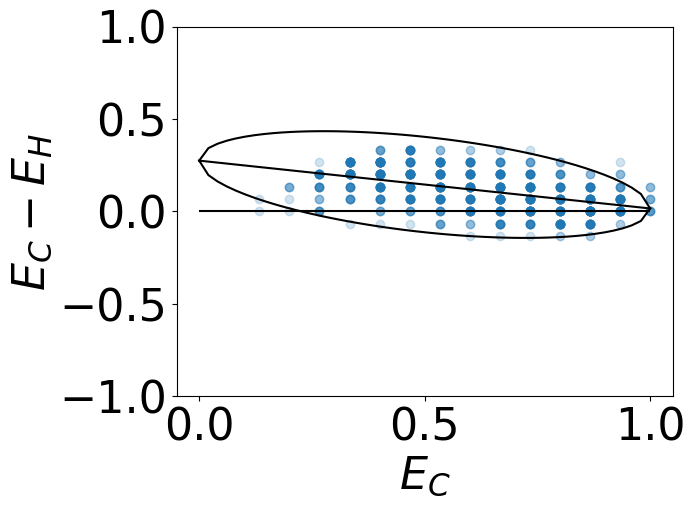

In [11]:
args, chi = sys_by_institution(MS, 'cornell', code = "SGW", N_bank = 20, N_trials = 100, n = 15)
cornell_args = args #the chi-squared value in the first round is based on an innacurate fit, use these args to do a correct fit in the next cell

/opt/anaconda3/envs/torch/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


49
19
0.7996630340226161
chi-squared =  0.80


/var/folders/ly/td3qyyp55xs1mmjwv9rnbfym0000gn/T/ipykernel_24120/79285681.py:54: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_out_SGW["error"][df_out_SGW["error"] < 0.0001] = np.sqrt(.99*(1-.99)/n)


((0.2747570510262814, -0.25866971992520627), '0.80')

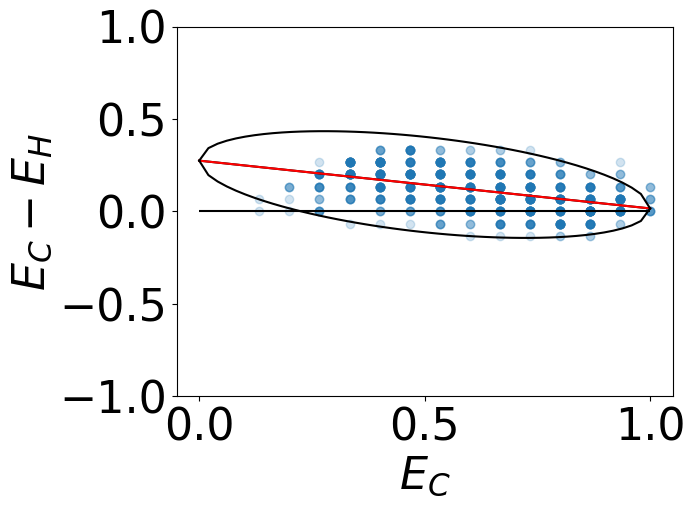

In [12]:
sys_by_institution(MS, 'cornell', code = "SGW", N_bank = 20, N_trials = 100, n = 15,main_fit_args = cornell_args)

/opt/anaconda3/envs/torch/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


56
35
3.8017093567848863
chi-squared =  3.80


/var/folders/ly/td3qyyp55xs1mmjwv9rnbfym0000gn/T/ipykernel_24120/79285681.py:54: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_out_SGW["error"][df_out_SGW["error"] < 0.0001] = np.sqrt(.99*(1-.99)/n)


((0.4808984099306682, -0.3725845942604403), '3.80')

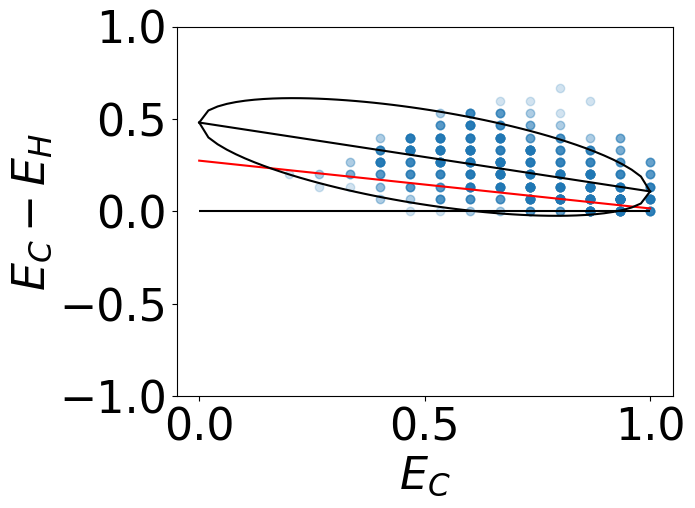

In [13]:
sys_by_institution(MS, 'ut', code = "SGW", N_bank = 20, N_trials = 100, n = 15,main_fit_args = cornell_args)

/opt/anaconda3/envs/torch/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


39
23
1.791718727685286
chi-squared =  1.79


/var/folders/ly/td3qyyp55xs1mmjwv9rnbfym0000gn/T/ipykernel_24120/79285681.py:54: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_out_SGW["error"][df_out_SGW["error"] < 0.0001] = np.sqrt(.99*(1-.99)/n)


((0.4044148631559739, -0.3710116372073254), '1.79')

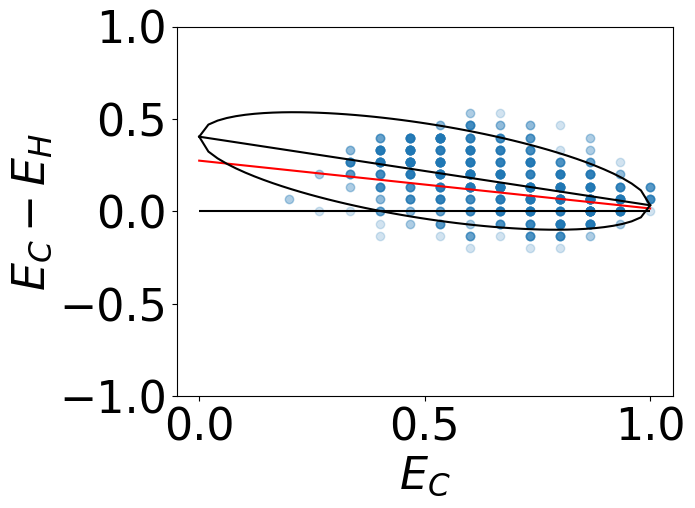

In [14]:
sys_by_institution(MS,'ncsu', code = "SGW", N_bank = 20, N_trials = 100, n = 15,main_fit_args = cornell_args)

/opt/anaconda3/envs/torch/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


21
19
0.9639733816334721
chi-squared =  0.96


/var/folders/ly/td3qyyp55xs1mmjwv9rnbfym0000gn/T/ipykernel_24120/79285681.py:54: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_out_SGW["error"][df_out_SGW["error"] < 0.0001] = np.sqrt(.99*(1-.99)/n)


((0.3643356645127246, -0.40949380213155906), '0.96')

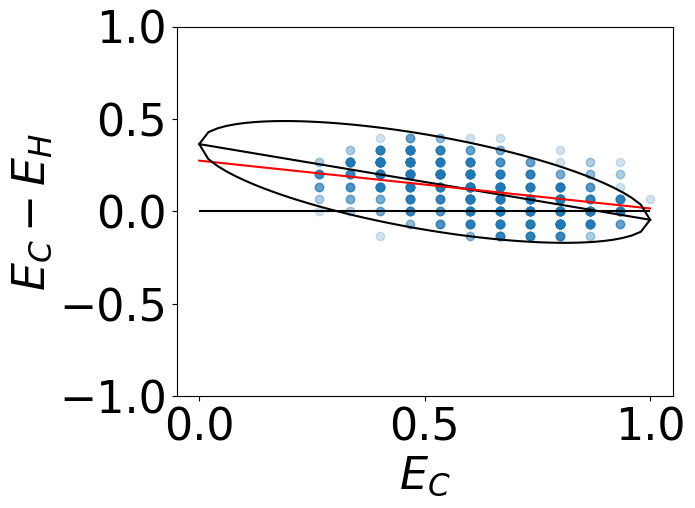

In [15]:
sys_by_institution(MS,'auburn', code = "SGW", N_bank = 20, N_trials = 100, n = 15,main_fit_args = cornell_args)

In [16]:
#there are some instances where statistical uncertainty is zeros because E_C = 0 or E_C = 1. Get around this by adding 0.001 to all points

In [19]:
%%time 
#train bert
y_train_CON = get_y("CON", train)
print(len(y_train_CON))

device='mps' #if using MacBook with M1 chip or higher
#device='cuda' #if using GPU. not available to run on CPU
batch_size = 16 

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
MAX_LEN_BERT = bu.get_max_len_bert(tokenizer, train, train, include_val=True)

train_data_CON, train_sampler_CON, train_dataloader_CON = bu.get_train_x_bert("CON", y_train_CON, train, batch_size, tokenizer, MAX_LEN_BERT, balanced = True)

epochs=3
bert_classifier, optimizer, scheduler = bu.initialize_model(device, epochs=epochs, train_dataloader = train_dataloader_CON)
bu.train_BERT(device, bert_classifier, optimizer, scheduler, train_dataloader_CON, val_dataloader=None, epochs=epochs, evaluation=False)

1216


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tokenizing data...


/opt/anaconda3/envs/torch/lib/python3.12/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.369262   |     -      |     -     |   7.99   
   1    |   40    |   0.276419   |     -      |     -     |   15.10  
   1    |   60    |   0.223303   |     -      |     -     |   22.22  
   1    |   75    |   0.208675   |     -      |     -     |   27.55  
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.109830   |     -      |     -     |   7.46   
   2    |   40    |   0.073198   |     -      |     -     |   14.57  
   2    |   60    |   0.059629   |     -      |     -     |   21.67  
   2    |   75    |   0.062666   |     -      |     -     |   27.01  
--------------------------------------------------------------------

18
50
405.95963252082385
chi-squared =  405.96


/var/folders/ly/td3qyyp55xs1mmjwv9rnbfym0000gn/T/ipykernel_24120/79285681.py:54: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_out_SGW["error"][df_out_SGW["error"] < 0.0001] = np.sqrt(.99*(1-.99)/n)


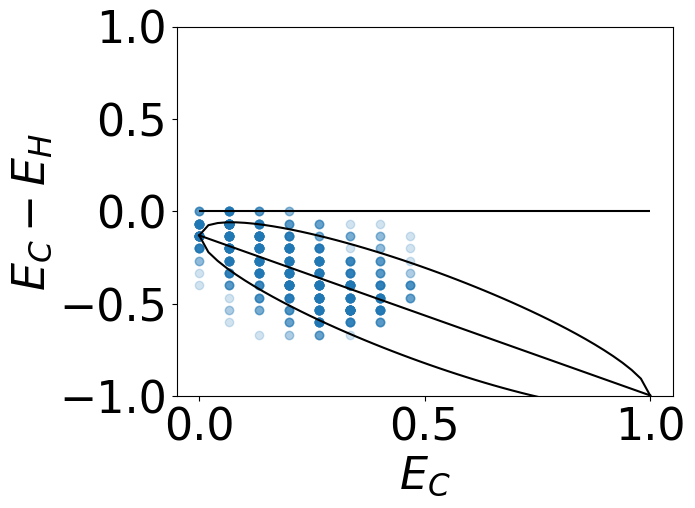

In [20]:
args, chi = sys_by_institution(MS, 'cornell', code = "CON", N_bank = 20, N_trials = 100, n = 15)
cornell_args = args  #the chi-squared value in the first round is based on an innacurate fit, use these args to do a correct fit in the next cell

/opt/anaconda3/envs/torch/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


18
50
2.5889790967959008
chi-squared =  2.59


/var/folders/ly/td3qyyp55xs1mmjwv9rnbfym0000gn/T/ipykernel_24120/79285681.py:54: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_out_SGW["error"][df_out_SGW["error"] < 0.0001] = np.sqrt(.99*(1-.99)/n)


((-0.12977812692868546, -0.865870076923527), '2.59')

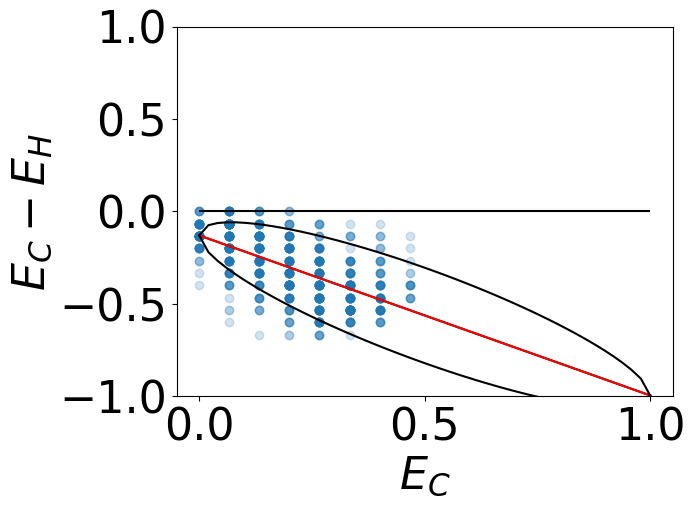

In [21]:
sys_by_institution(MS, 'cornell', code = "CON", N_bank = 20, N_trials = 100, n = 15,main_fit_args = cornell_args)

/opt/anaconda3/envs/torch/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


28
63
6.015239975458934
chi-squared =  6.02


/var/folders/ly/td3qyyp55xs1mmjwv9rnbfym0000gn/T/ipykernel_24120/79285681.py:54: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_out_SGW["error"][df_out_SGW["error"] < 0.0001] = np.sqrt(.99*(1-.99)/n)


((-0.18675907549367732, -0.6409411803712813), '6.02')

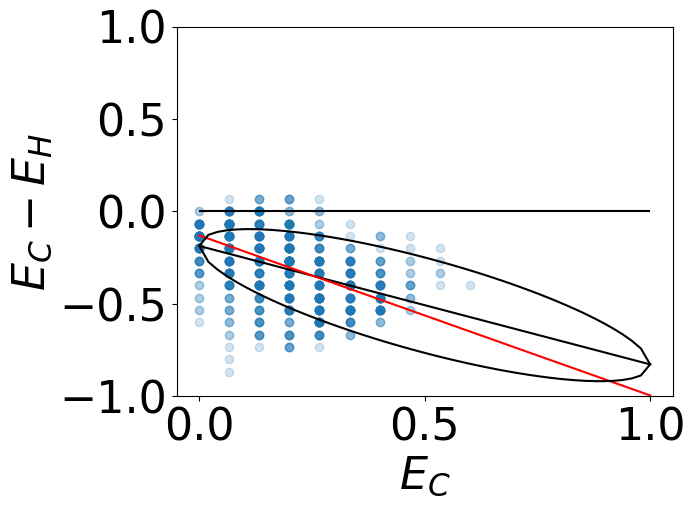

In [22]:
sys_by_institution(MS, 'ut', code = "CON", N_bank = 20, N_trials = 100, n = 15,main_fit_args = cornell_args)

/opt/anaconda3/envs/torch/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


22
40
5.9232944334322255
chi-squared =  5.92


/var/folders/ly/td3qyyp55xs1mmjwv9rnbfym0000gn/T/ipykernel_24120/79285681.py:54: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_out_SGW["error"][df_out_SGW["error"] < 0.0001] = np.sqrt(.99*(1-.99)/n)


((-0.15574330804498585, -0.8942401554167446), '5.92')

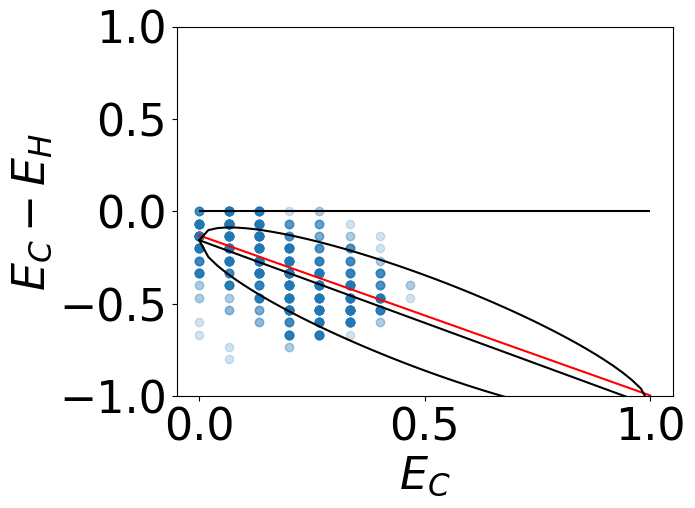

In [23]:
sys_by_institution(MS, 'ncsu', code = "CON", N_bank = 20, N_trials = 100, n = 15,main_fit_args = cornell_args)

/opt/anaconda3/envs/torch/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


8
32
17.48369176087273
chi-squared =  17.48


/var/folders/ly/td3qyyp55xs1mmjwv9rnbfym0000gn/T/ipykernel_24120/79285681.py:54: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_out_SGW["error"][df_out_SGW["error"] < 0.0001] = np.sqrt(.99*(1-.99)/n)


((-0.2621187076173813, -0.18836629871229316), '17.48')

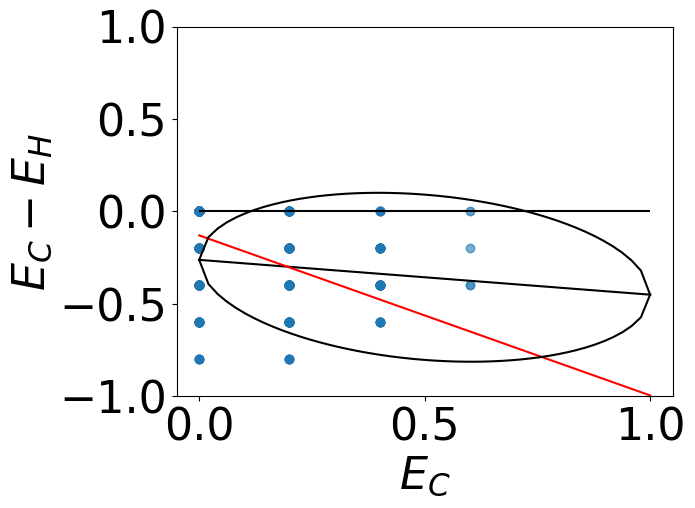

In [24]:
sys_by_institution(MS, 'auburn', code = "CON", N_bank = 8, N_trials = 100, n = 5,main_fit_args = cornell_args)

We acknowledge Megan Flynn for collaborative work on some of the functions used in this notebook. 